In [1]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats
import scipy.sparse as sparse

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1]]
                data.append(columns)

    return data

def import_csv2(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10] ]
                data.append(columns)

    return data

def import_csv3(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10], row[11] ]
                data.append(columns)

    return data

def import_csv4(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4]]
                data.append(columns)

    return data

In [3]:
tcp_cca = (['TcpCubic', 'TcpBbr', 'TcpQtOptimal_1.1minRTT', 'TcpQtOptimal_1.2minRTT', 'TcpQtOptimal_1.3minRTT'
           , 'TcpQtOptimal_1.4minRTT', 'TcpQtOptimal_1.5minRTT'])
BDP = 172
buffer_size = 518 
print(buffer_size, tcp_cca)

518 ['TcpCubic', 'TcpBbr', 'TcpQtOptimal_1.1minRTT', 'TcpQtOptimal_1.2minRTT', 'TcpQtOptimal_1.3minRTT', 'TcpQtOptimal_1.4minRTT', 'TcpQtOptimal_1.5minRTT']


In [4]:
num_flows = 1
cwnd = {}
agg_cwnd = {}
inflight = {}
rtt = {}

for algorithm in tcp_cca:
    cwnd[algorithm] = {}
    agg_cwnd[algorithm] = {}
    inflight[algorithm] = {}
    rtt[algorithm] = {}


    agg_cwnd[algorithm] = {'time': list(), 'agg_cwnd': list(), 'agg_inflight': list(),
                'aveRtt': list(), 'agg_insThruput': list(), 'agg_aveThruput': list(), 
                'agg_insGoodput': list(), 'agg_aveGoodput': list(), 'agg_TxPkts': list(), 
                'agg_ReTxPkts': list(), 'fairness': list(), 'agg_cost': list()}
        
    for i in range(num_flows):
        cwnd[algorithm][i] = {'time': list(), 'cwnd': list(), 'inflight': list(),
                'rtt': list(), 'insThruput': list(), 'aveThruput': list(), 
                'insGoodput': list(), 'aveGoodput': list(), 'TxPkts': list(), 'ReTxPkts': list(), 
                'cost': list()}
                                       
        inflight[algorithm][i] = {'time': list(), 'inflight': list(), 'cwnd': list(), 
                                           'rtt': list(), 'cost': list()}
        rtt[algorithm][i] = {'time': list(), 'rtt': list()}

cwnd_files = []
agg_cwnd_files = []
inflight_files = []
rtt_files = []
                                               
for algorithm in tcp_cca:
    print(algorithm)
    cwnd_sim_files = []
    
    agg_cwnd_files.append("../results/tcp_qt_optimal_sims_wireless/" + str(algorithm) + "/" + 
                str(num_flows)  + "-flows/10Mbps-100ms/" + str(buffer_size) + "p-btlqueue/" + 
                algorithm + "-" + str(num_flows) + "-flows-10Mbps-100ms-" + str(buffer_size) +
                "p-" + "Agg" + "-cwnd.data")
    cwnd_flows_files = []
    inflight_flows_files = []
    rtt_flows_files = []
    
    for i in range(num_flows):
        cwnd_flows_files.append("../results/tcp_qt_optimal_sims_wireless/" + str(algorithm) + "/" + 
                    str(num_flows)  + "-flows/10Mbps-100ms/" + str(buffer_size) + "p-btlqueue/" + 
                    algorithm + "-" + str(num_flows) + "-flows-10Mbps-100ms-" + str(buffer_size) +
                    "p-flow" + str(i) + "-cwnd.data")
        inflight_flows_files.append("../results/tcp_qt_optimal_sims_wireless/" + str(algorithm) + "/" + 
                    str(num_flows)  + "-flows/10Mbps-100ms/" + str(buffer_size) + "p-btlqueue/" + 
                    algorithm + "-" + str(num_flows) + "-flows-10Mbps-100ms-" + str(buffer_size) +
                    "p-flow" + str(i) + "-inflight.data")
        rtt_flows_files.append("../results/tcp_qt_optimal_sims_wireless/" + str(algorithm) + "/" + 
                        str(num_flows)  + "-flows/10Mbps-100ms/" + str(buffer_size) + "p-btlqueue/" + 
                        algorithm + "-" + str(num_flows) + "-flows-10Mbps-100ms-" + str(buffer_size) +
                        "p-flow" + str(i) + "-rtt.data")
        
        cwnd_files.append(cwnd_flows_files)
        inflight_files.append(inflight_flows_files)
        rtt_files.append(rtt_flows_files)



TcpCubic
TcpBbr
TcpQtOptimal_1.1minRTT
TcpQtOptimal_1.2minRTT
TcpQtOptimal_1.3minRTT
TcpQtOptimal_1.4minRTT
TcpQtOptimal_1.5minRTT


In [5]:
print(agg_cwnd_files[0])
print(agg_cwnd_files[1])
print(agg_cwnd_files[2])

../results/tcp_qt_optimal_sims_wireless/TcpCubic/1-flows/10Mbps-100ms/518p-btlqueue/TcpCubic-1-flows-10Mbps-100ms-518p-Agg-cwnd.data
../results/tcp_qt_optimal_sims_wireless/TcpBbr/1-flows/10Mbps-100ms/518p-btlqueue/TcpBbr-1-flows-10Mbps-100ms-518p-Agg-cwnd.data
../results/tcp_qt_optimal_sims_wireless/TcpQtOptimal_1.1minRTT/1-flows/10Mbps-100ms/518p-btlqueue/TcpQtOptimal_1.1minRTT-1-flows-10Mbps-100ms-518p-Agg-cwnd.data


In [6]:

for algorithm  in tcp_cca:
    index_alg = tcp_cca.index(algorithm)
    print(algorithm,index_alg)

    agg_cwnd_data_in = import_csv3(agg_cwnd_files[index_alg])
    for row in agg_cwnd_data_in: 
        agg_cwnd[algorithm]['time'].append({row[0]})
        agg_cwnd[algorithm]['agg_cwnd'].append({row[1]})
        agg_cwnd[algorithm]['agg_inflight'].append({row[2]})
        agg_cwnd[algorithm]['aveRtt'].append({row[3]})
        agg_cwnd[algorithm]['agg_insThruput'].append({row[4]})
        agg_cwnd[algorithm]['agg_aveThruput'].append({row[5]})
        agg_cwnd[algorithm]['agg_insGoodput'].append({row[6]})
        agg_cwnd[algorithm]['agg_aveGoodput'].append({row[7]})
        agg_cwnd[algorithm]['agg_TxPkts'].append({row[8]})
        agg_cwnd[algorithm]['agg_ReTxPkts'].append({row[9]})
        agg_cwnd[algorithm]['fairness'].append({row[10]})
        agg_cwnd[algorithm]['agg_cost'].append({row[11]})

    for i in range(num_flows):
        cwnd_data_in = import_csv2(cwnd_files[index_alg][i])
        inflight_data_in = import_csv4(inflight_files[index_alg][i])
        rtt_data_in = import_csv(rtt_files[index_alg][i])

        for row in cwnd_data_in:
            cwnd[algorithm][i]['time'].append({row[0]})
            cwnd[algorithm][i]['cwnd'].append({row[1]})
            cwnd[algorithm][i]['inflight'].append({row[2]})
            cwnd[algorithm][i]['rtt'].append({row[3]})
            cwnd[algorithm][i]['insThruput'].append({row[4]})
            cwnd[algorithm][i]['aveThruput'].append({row[5]})
            cwnd[algorithm][i]['insGoodput'].append({row[6]})
            cwnd[algorithm][i]['aveGoodput'].append({row[7]})
            cwnd[algorithm][i]['TxPkts'].append({row[8]})
            cwnd[algorithm][i]['ReTxPkts'].append({row[9]})
            cwnd[algorithm][i]['cost'].append({row[10]})
            
        for row in inflight_data_in:
            inflight[algorithm][i]['time'].append({row[0]})
            inflight[algorithm][i]['inflight'].append({row[1]})
            inflight[algorithm][i]['cwnd'].append({row[2]})
            inflight[algorithm][i]['rtt'].append({row[3]})
            inflight[algorithm][i]['cost'].append({row[4]})

        for row in rtt_data_in:
            rtt[algorithm][i]['time'].append({row[0]})
            rtt[algorithm][i]['rtt'].append({row[1]})


TcpCubic 0
TcpBbr 1
TcpQtOptimal_1.1minRTT 2
TcpQtOptimal_1.2minRTT 3
TcpQtOptimal_1.3minRTT 4
TcpQtOptimal_1.4minRTT 5
TcpQtOptimal_1.5minRTT 6


In [7]:
cwnd_time = []
cwnd_value = []
inflight_value = []
rtt_value = []
insThruput_value = []
aveThruput_value = []
insGoodput_value = []
aveGoodput_value = []
cost_value = []

inflight2_time = []
inflight2_value = []
cwnd2_value = []
rtt2_value = []
cost2_value = []
rtt3_time = []
rtt3_value = []

agg_cwnd_time = []
agg_cwnd_value = []
agg_inflight_value = []
agg_rtt_value = []
agg_insThruput_value = []
agg_aveThruput_value = []
agg_insGoodput_value = []
agg_aveGoodput_value = []
fairness_value = []
agg_cost_value = []

for algorithm in tcp_cca:
    print(algorithm)
    cwnd_time_ = []
    cwnd_value_ = []
    inflight_value_ = []
    rtt_value_ = []
    insThruput_value_ = []
    aveThruput_value_ = []
    insGoodput_value_ = []
    aveGoodput_value_ = []
    cost_value_ = []
    
    inflight2_time_ = []
    inflight2_value_ = []
    cwnd2_value_ = []
    rtt2_value_ = []
    cost2_value_ = []
    rtt3_time_ = []
    rtt3_value_ = []
    

    agg_cwnd_time.append(pd.DataFrame(agg_cwnd[algorithm]['time']))
    agg_cwnd_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cwnd']))
    agg_inflight_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_inflight']))
    agg_rtt_value.append(pd.DataFrame(agg_cwnd[algorithm]['aveRtt']))
    agg_insThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insThruput']))  
    agg_aveThruput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveThruput']))  
    agg_insGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_insGoodput']))  
    agg_aveGoodput_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_aveGoodput'])) 
    fairness_value.append(pd.DataFrame(agg_cwnd[algorithm]['fairness'])) 
    agg_cost_value.append(pd.DataFrame(agg_cwnd[algorithm]['agg_cost'])) 
    
    
    for i in range(num_flows):
        cwnd_time_.append(pd.DataFrame(cwnd[algorithm][i]['time']))
        cwnd_value_.append(pd.DataFrame(cwnd[algorithm][i]['cwnd']))
        cost_value_.append(pd.DataFrame(cwnd[algorithm][i]['cost']))
        inflight_value_.append(pd.DataFrame(cwnd[algorithm][i]['inflight']))
        rtt_value_.append(pd.DataFrame(cwnd[algorithm][i]['rtt']))
        insThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insThruput']))  
        aveThruput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveThruput']))  
        insGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['insGoodput']))  
        aveGoodput_value_.append(pd.DataFrame(cwnd[algorithm][i]['aveGoodput'])) 
        
        inflight2_time_.append(pd.DataFrame(inflight[algorithm][i]['time']))
        inflight2_value_.append(pd.DataFrame(inflight[algorithm][i]['inflight']))
        cwnd2_value_.append(pd.DataFrame(inflight[algorithm][i]['cwnd']))
        rtt2_value_.append(pd.DataFrame(inflight[algorithm][i]['rtt']))
        cost2_value_.append(pd.DataFrame(inflight[algorithm][i]['cost']))
        
        rtt3_time_.append(pd.DataFrame(rtt[algorithm][i]['time']))
        rtt3_value_.append(pd.DataFrame(rtt[algorithm][i]['rtt']))
        
    cwnd_time.append(cwnd_time_)
    cwnd_value.append(cwnd_value_)
    cost_value.append(cost_value_)
    inflight_value.append(inflight_value_)
    rtt_value.append(rtt_value_)
    insThruput_value.append(insThruput_value_)
    aveThruput_value.append(aveThruput_value_)
    insGoodput_value.append(insGoodput_value_)
    aveGoodput_value.append(aveGoodput_value_)
    
    inflight2_time.append(inflight2_time_)
    inflight2_value.append(inflight2_value_)
    cwnd2_value.append(cwnd2_value_)
    rtt2_value.append(rtt2_value_)
    cost2_value.append(cost2_value_)
    
    rtt3_time.append(rtt3_time_)
    rtt3_value.append(rtt3_value_)


TcpCubic
TcpBbr
TcpQtOptimal_1.1minRTT
TcpQtOptimal_1.2minRTT
TcpQtOptimal_1.3minRTT
TcpQtOptimal_1.4minRTT
TcpQtOptimal_1.5minRTT


/tmp/ipykernel_27112/3729718584.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


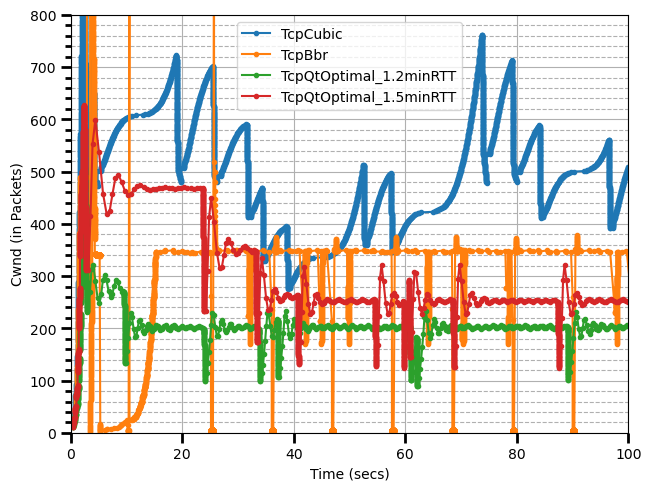

In [8]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), cwnd_value[0][0].to_numpy(dtype=float)/1448.0, '.-',
        cwnd_time[1][0].to_numpy(dtype=float), cwnd_value[1][0].to_numpy(dtype=float)/1448,'.-',
        cwnd_time[3][0].to_numpy(dtype=float), cwnd_value[3][0].to_numpy(dtype=float)/1448,'.-',
        cwnd_time[6][0].to_numpy(dtype=float), cwnd_value[6][0].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), cwnd_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Cwnd (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,800)
plt.xlim(0,100)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('cwnd_for_all.png', transparent=True)


/tmp/ipykernel_27112/4221308935.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


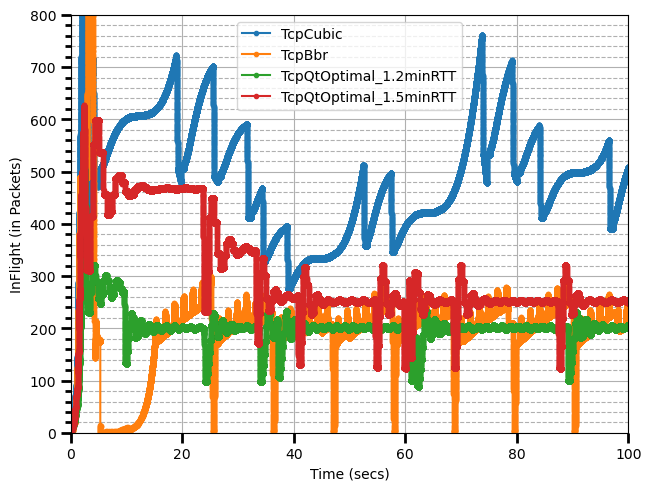

In [16]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        inflight2_time[0][0].to_numpy(dtype=float), inflight2_value[0][0].to_numpy(dtype=float)/1448.0, '.-',
        inflight2_time[1][0].to_numpy(dtype=float), inflight2_value[1][0].to_numpy(dtype=float)/1448,'.-',
        inflight2_time[3][0].to_numpy(dtype=float), inflight2_value[3][0].to_numpy(dtype=float)/1448,'.-',
        inflight2_time[6][0].to_numpy(dtype=float), inflight2_value[6][0].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        inflight2_time[1].to_numpy(dtype=float), inflight2_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'InFlight (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,800)
plt.xlim(0,100)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('inflight2_for_all2.png', transparent=True)

/tmp/ipykernel_27112/186604923.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


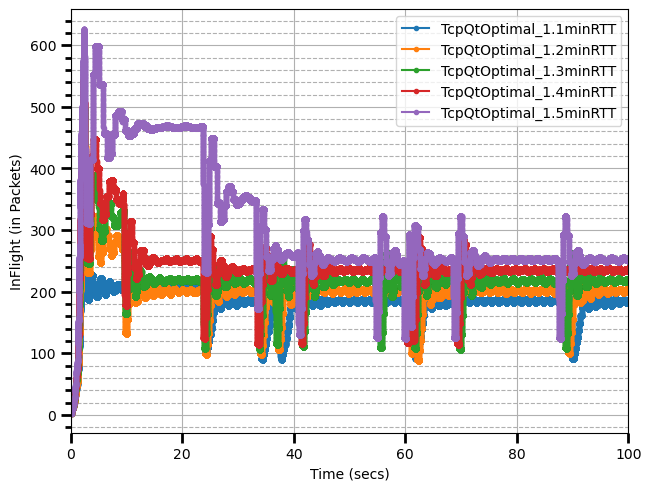

In [17]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        inflight2_time[2][0].to_numpy(dtype=float), inflight2_value[2][0].to_numpy(dtype=float)/1448,'.-',
        inflight2_time[3][0].to_numpy(dtype=float), inflight2_value[3][0].to_numpy(dtype=float)/1448,'.-',
        inflight2_time[4][0].to_numpy(dtype=float), inflight2_value[4][0].to_numpy(dtype=float)/1448,'.-',
        inflight2_time[5][0].to_numpy(dtype=float), inflight2_value[5][0].to_numpy(dtype=float)/1448,'.-',
        inflight2_time[6][0].to_numpy(dtype=float), inflight2_value[6][0].to_numpy(dtype=float)/1448,'.-',
        )
#ax1.step(
#        inflight2_time[1].to_numpy(dtype=float), inflight2_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'InFlight (in Packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(100,300)
plt.xlim(0,100)
plt.grid(True)
plt.legend([
            tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('QtOptimal_inflight_for_Rtargets.png', transparent=True)


/tmp/ipykernel_27112/1463091558.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


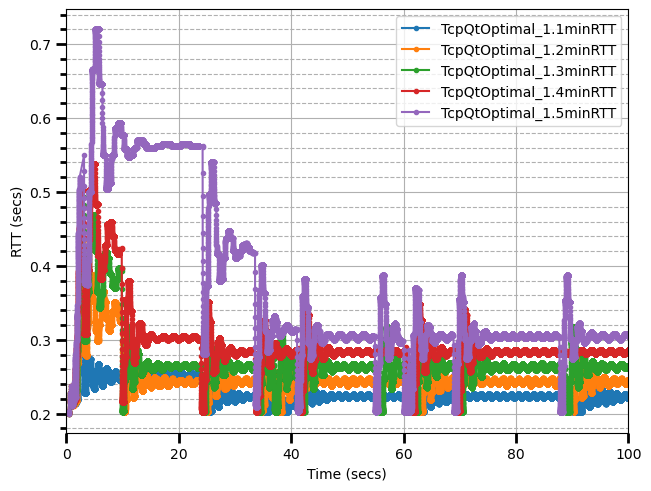

In [18]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        rtt3_time[2][0].to_numpy(dtype=float), rtt3_value[2][0].to_numpy(dtype=float),'.-',
        rtt3_time[3][0].to_numpy(dtype=float), rtt3_value[3][0].to_numpy(dtype=float),'.-',
        rtt3_time[4][0].to_numpy(dtype=float), rtt3_value[4][0].to_numpy(dtype=float),'.-',
        rtt3_time[5][0].to_numpy(dtype=float), rtt3_value[5][0].to_numpy(dtype=float),'.-',
        rtt3_time[6][0].to_numpy(dtype=float), rtt3_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        rtt3_time[1].to_numpy(dtype=float), rtt3_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'RTT (secs)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(100,300)
plt.xlim(0,100)
plt.grid(True)
plt.legend([
            tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('QtOptimal_RTT_for_Rtargets.png', transparent=True)


/tmp/ipykernel_27112/1918825787.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


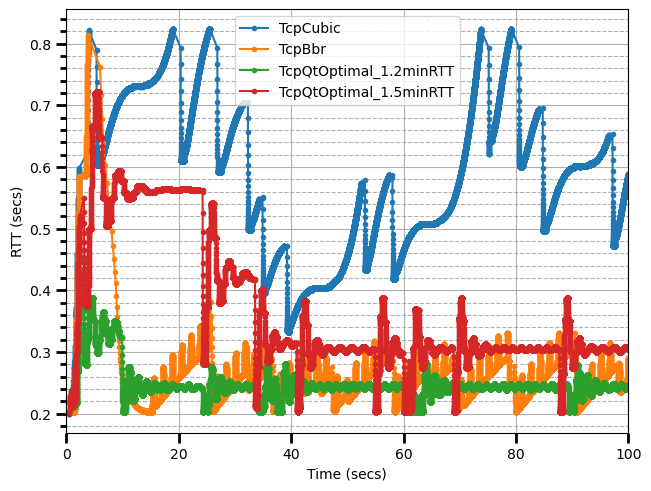

In [19]:
ig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        rtt3_time[0][0].to_numpy(dtype=float), rtt3_value[0][0].to_numpy(dtype=float),'.-',
        rtt3_time[1][0].to_numpy(dtype=float), rtt3_value[1][0].to_numpy(dtype=float),'.-',
        rtt3_time[3][0].to_numpy(dtype=float), rtt3_value[3][0].to_numpy(dtype=float),'.-',
        rtt3_time[6][0].to_numpy(dtype=float), rtt3_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        rtt3_time[1].to_numpy(dtype=float), rtt3_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'RTT (secs)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(100,300)
plt.xlim(0,100)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('RTT_for_all.png', transparent=True)


/tmp/ipykernel_27112/290973683.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


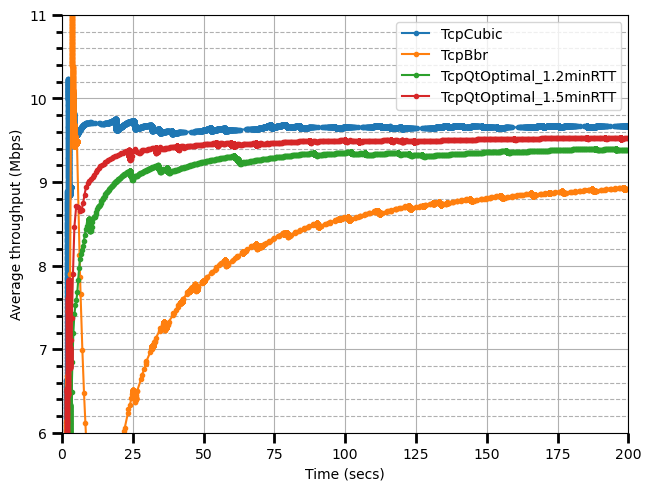

In [13]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), aveThruput_value[0][0].to_numpy(dtype=float), '.-',
        cwnd_time[1][0].to_numpy(dtype=float), aveThruput_value[1][0].to_numpy(dtype=float),'.-',
        cwnd_time[3][0].to_numpy(dtype=float), aveThruput_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), aveThruput_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveThruput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average throughput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(6,11)
plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('avethruput_for_all.png', transparent=True)

/tmp/ipykernel_27112/2988132992.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


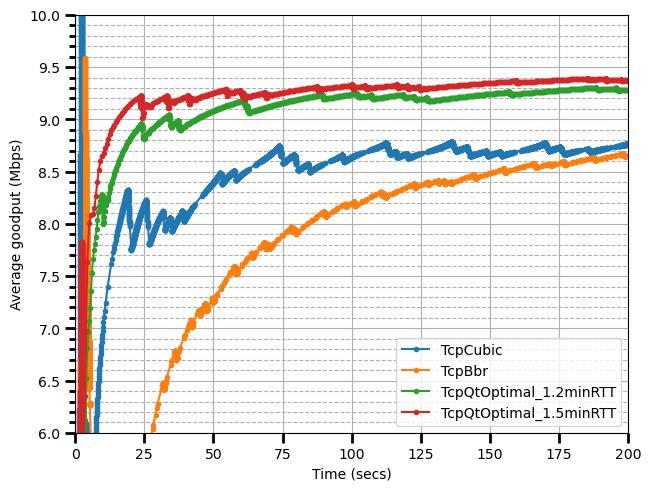

In [14]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), aveGoodput_value[0][0].to_numpy(dtype=float), '.-',
        cwnd_time[1][0].to_numpy(dtype=float), aveGoodput_value[1][0].to_numpy(dtype=float),'.-',
        cwnd_time[3][0].to_numpy(dtype=float), aveGoodput_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), aveGoodput_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(6,10)
plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('avegoodput_for_all.png', transparent=True)

/tmp/ipykernel_27112/3458789438.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


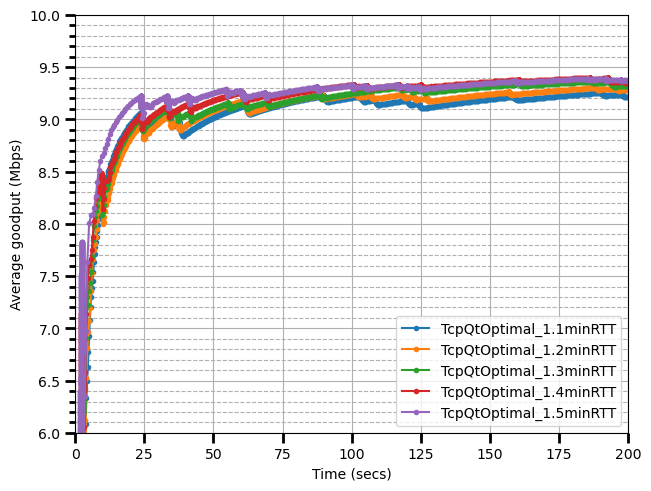

In [21]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[2][0].to_numpy(dtype=float), aveGoodput_value[2][0].to_numpy(dtype=float), '.-',
        cwnd_time[3][0].to_numpy(dtype=float), aveGoodput_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[4][0].to_numpy(dtype=float), aveGoodput_value[4][0].to_numpy(dtype=float),'.-',
        cwnd_time[5][0].to_numpy(dtype=float), aveGoodput_value[5][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), aveGoodput_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(6,10)
plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('QtOptimal_avegoodput.png', transparent=True)

/tmp/ipykernel_27112/2559085590.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


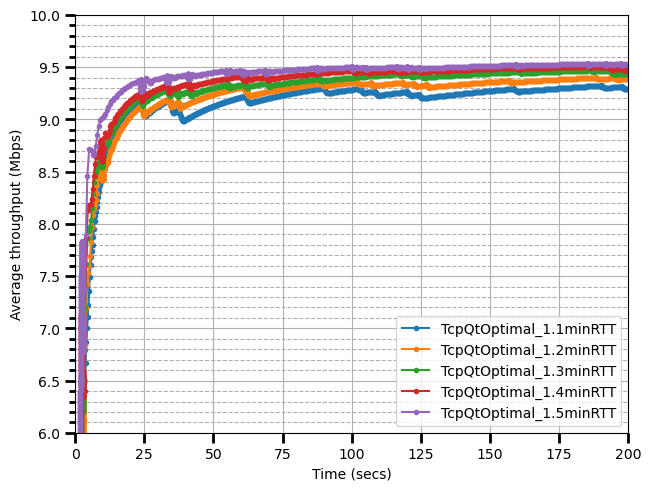

In [23]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[2][0].to_numpy(dtype=float), aveThruput_value[2][0].to_numpy(dtype=float), '.-',
        cwnd_time[3][0].to_numpy(dtype=float), aveThruput_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[4][0].to_numpy(dtype=float), aveThruput_value[4][0].to_numpy(dtype=float),'.-',
        cwnd_time[5][0].to_numpy(dtype=float), aveThruput_value[5][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), aveThruput_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), aveThruput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average throughput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(6,10)
plt.xlim(0,200)
plt.grid(True)
plt.legend([
            tcp_cca[2], tcp_cca[3], tcp_cca[4], tcp_cca[5], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('QtOptimal_aveThruput.png', transparent=True)

/tmp/ipykernel_27112/471724659.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


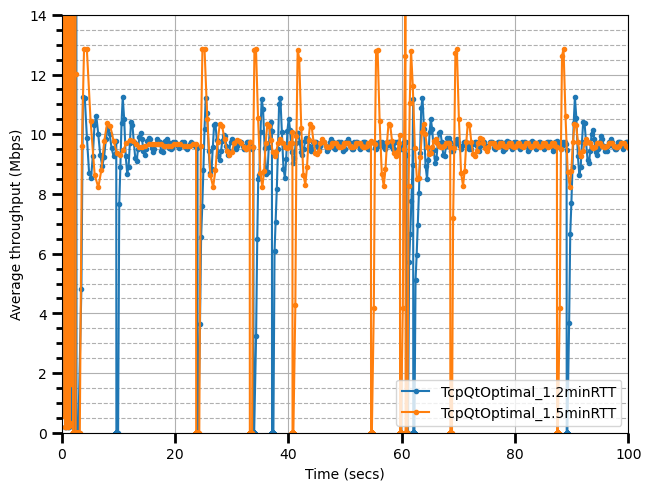

In [25]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[3][0].to_numpy(dtype=float), insGoodput_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), insGoodput_value[6][0].to_numpy(dtype=float),'.-',
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average throughput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,14)
plt.xlim(0,100)
plt.grid(True)
plt.legend([
            tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('insgoodput_for_qtoptimal.png', transparent=True)

/tmp/ipykernel_27112/2041739296.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


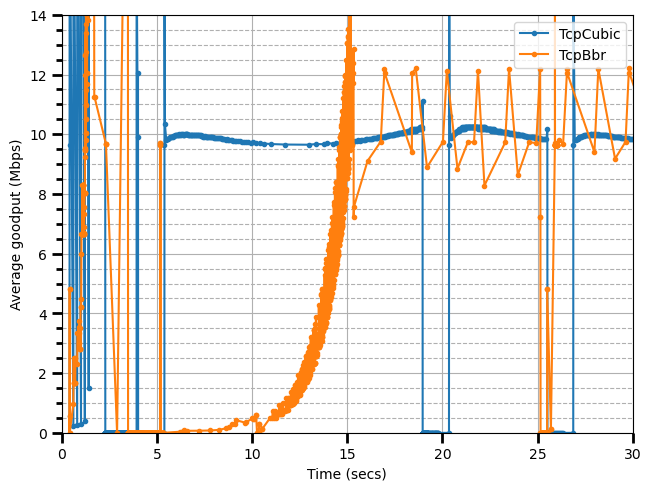

In [26]:
ig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), insGoodput_value[0][0].to_numpy(dtype=float),'.-',
        cwnd_time[1][0].to_numpy(dtype=float), insGoodput_value[1][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), insGoodput_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,14)
plt.xlim(0,30)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('insgoodput_for_cubic_and_bbr.png', transparent=True)

/tmp/ipykernel_27112/1751629751.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


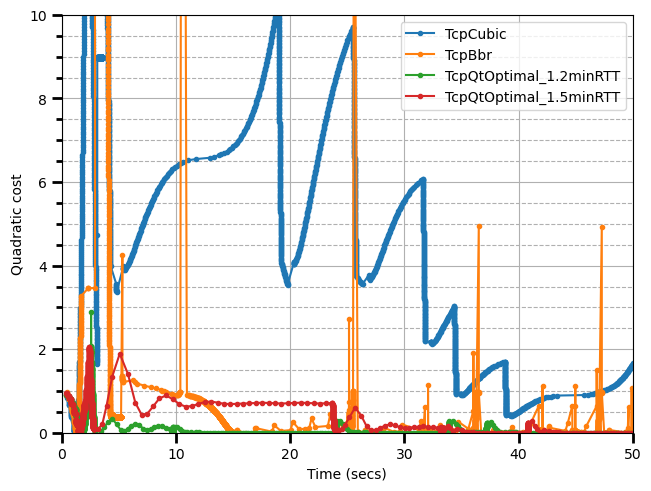

In [27]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), cost_value[0][0].to_numpy(dtype=float), '.-',
        cwnd_time[1][0].to_numpy(dtype=float), cost_value[1][0].to_numpy(dtype=float),'.-',
        cwnd_time[3][0].to_numpy(dtype=float), cost_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), cost_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), cost_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Quadratic cost')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,10)
plt.xlim(0,50)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('cost_for_all.png', transparent=True)

/tmp/ipykernel_27112/4126959429.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


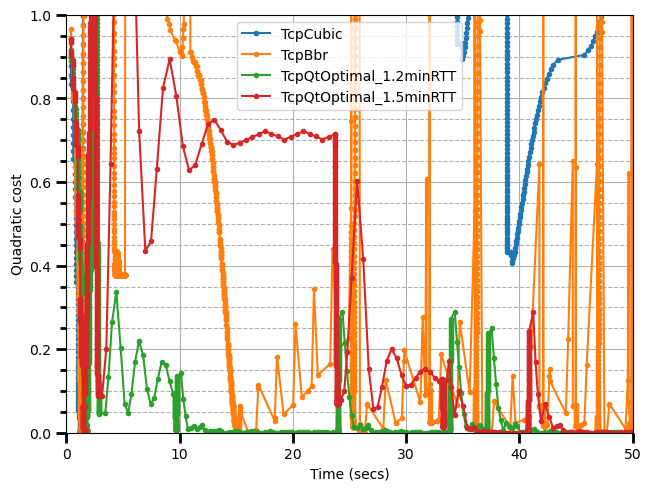

In [28]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), cost_value[0][0].to_numpy(dtype=float), '.-',
        cwnd_time[1][0].to_numpy(dtype=float), cost_value[1][0].to_numpy(dtype=float),'.-',
        cwnd_time[3][0].to_numpy(dtype=float), cost_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), cost_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), cost_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Quadratic cost')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,1)
plt.xlim(0,50)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('cost_for_all_zoomed.png', transparent=True)

/tmp/ipykernel_27112/2997998728.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


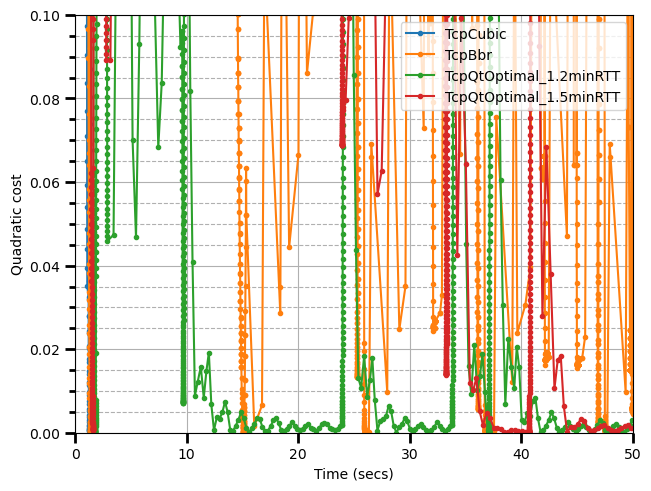

In [29]:
fig, ax1 = plt.subplots(constrained_layout=True)

ax1.plot(
        cwnd_time[0][0].to_numpy(dtype=float), cost_value[0][0].to_numpy(dtype=float), '.-',
        cwnd_time[1][0].to_numpy(dtype=float), cost_value[1][0].to_numpy(dtype=float),'.-',
        cwnd_time[3][0].to_numpy(dtype=float), cost_value[3][0].to_numpy(dtype=float),'.-',
        cwnd_time[6][0].to_numpy(dtype=float), cost_value[6][0].to_numpy(dtype=float),'.-',
        )
#ax1.step(
#        cwnd_time[1].to_numpy(dtype=float), cost_value[1].to_numpy(dtype=float),'x-', where='post'
#        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Time (secs)')
plt.ylabel(r'Quadratic cost')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,0.1)
plt.xlim(0,50)
plt.grid(True)
plt.legend([
            tcp_cca[0], tcp_cca[1], tcp_cca[3], tcp_cca[6]
           ], loc = 'best')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('cost_for_all_zoomedzoomed.png', transparent=True)